In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

import torch

In [2]:
# dataset load
data = pd.read_csv("/home/dataset/complete.csv")
data_only_pm25 = pd.DataFrame(data.loc[:, ["PM-2.5", "일시"]])
data_only_pm25["일시"] = pd.to_datetime(data_only_pm25["일시"])
data_only_pm25.index = data_only_pm25["일시"]
del data_only_pm25["일시"]
data_only_pm25.info()
data = data_only_pm25.iloc[50:, :]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2029 entries, 2018-02-01 to 2023-08-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PM-2.5  2029 non-null   float64
dtypes: float64(1)
memory usage: 31.7 KB


In [21]:
result_dict = {}

# Neural Network

In [4]:
class TimeSeriesDataset(torch.utils.data.Dataset):
  def __init__(self, ts:np.array, lookback_size:int, forecast_size:int):
    self.lookback_size = lookback_size
    self.forecast_size = forecast_size
    self.data = ts

  def __len__(self):
    return len(self.data) - self.lookback_size - self.forecast_size + 1

  def __getitem__(self, i):
    idx = (i+self.lookback_size)
    look_back = self.data[i:idx]
    forecast = self.data[idx:idx+self.forecast_size]

    return look_back, forecast

In [5]:
from sklearn.preprocessing import MinMaxScaler

lookback_size = 9
forecast_size = 4
tst_size=200
scaler = MinMaxScaler()
trn_scaled = scaler.fit_transform(data[:-tst_size].to_numpy(dtype=np.float32)).flatten()
tst_scaled = scaler.transform(data[-tst_size-lookback_size:].to_numpy(dtype=np.float32)).flatten()

trn_ds = TimeSeriesDataset(trn_scaled, lookback_size, forecast_size)
tst_ds = TimeSeriesDataset(tst_scaled, lookback_size, forecast_size)

trn_dl = torch.utils.data.DataLoader(trn_ds, batch_size=32, shuffle=True)
tst_dl = torch.utils.data.DataLoader(tst_ds, batch_size=tst_size, shuffle=False)

In [6]:
x, y = next(iter(trn_dl))

x.shape[1], y.shape

(9, torch.Size([32, 4]))

In [25]:
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
  def __init__(self, d_in, d_out, d_hidden, activation=F.relu):
    super().__init__()
    self.lin1 = nn.Linear(d_in, d_hidden)
    self.lin2 = nn.Linear(d_hidden, d_out)
    self.activation = activation

  def forward(self, x):
    x = self.lin1(x)
    x = self.activation(x)
    x = self.lin2(x)
    return F.sigmoid(x)

In [26]:
import tqdm
from tqdm.auto import trange

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = Net(9, 4, 512)
net.to(device)

optim = torch.optim.AdamW(net.parameters(), lr=0.0001)

pbar = trange(100)
for i in pbar:
  net.train()
  trn_loss = .0
  for x, y in trn_dl:
    x, y = x.to(device), y.to(device)
    p = net(x)
    optim.zero_grad()
    loss = F.mse_loss(p, y)
    loss.backward()
    optim.step()
    trn_loss += loss.item()*len(y)
  trn_loss = trn_loss/len(trn_ds)

  net.eval()
  with torch.inference_mode():
    x, y = next(iter(tst_dl))
    x, y = x.to(device), y.to(device)
    p = net(x)
    tst_loss = F.mse_loss(p,y)
    # tst_mape = mape(p,y)
    # tst_mae = mae(p,y)
  pbar.set_postfix({'loss':trn_loss, 'tst_loss':tst_loss.item()})#, 'tst_mape':tst_mape.item(), 'tst_mae':tst_mae.item()})

  0%|          | 0/100 [00:00<?, ?it/s]

In [27]:
net.eval()
with torch.inference_mode():
  x, y = next(iter(tst_dl))
  x, y = x.to(device), y.to(device)
  p = net(x)

def mape(y_pred, y_true):
  return (np.abs(y_pred - y_true)/y_true).mean() * 100

def mae(y_pred, y_true):
  return np.abs(y_pred - y_true).mean()

y = scaler.inverse_transform(y.cpu())
p = scaler.inverse_transform(p.cpu())

y = np.concatenate([y[:,0], y[-1,1:]])
p = np.concatenate([p[:,0], p[-1,1:]])

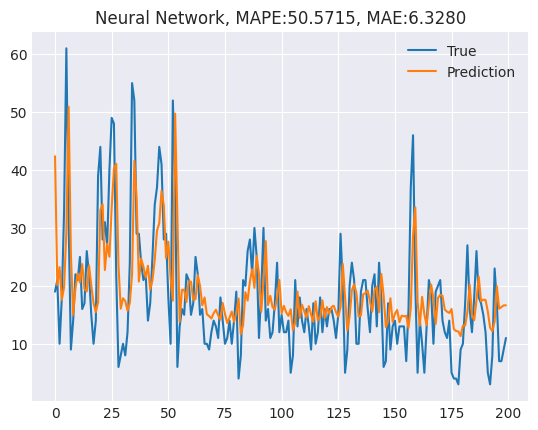

NameError: name 'res_dict' is not defined

In [28]:
plt.title(f"Neural Network, MAPE:{mape(p,y):.4f}, MAE:{mae(p,y):.4f}")
plt.plot(range(tst_size), y, label="True")
plt.plot(range(tst_size), p, label="Prediction")
plt.legend()
plt.show()

res_dict.update({'NN(9,512,4)': {'MAPE':mape(p,y), 'MAE':mae(p,y)}})